# improve-performance-issue18
## Prepare_DIVA_Input_WOD_interp_profiles_to_standard_levels
21 September 2023

https://github.com/CARSv2/cars-v2/issues/18

In [3]:
import xarray
import fsspec
import numpy as np
import s3fs
#import proplot
import os

from matplotlib import pyplot as plt
import pandas

In [11]:
from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [12]:
def CSIRO_standard_levels():
    
    depth_levels  = np.asarray([2,5,10,20,30,40,50,60,70,75,80,90,100,110,120,125,130,140,150,160,170,175,180,190,200,
                               210,220,225,230,240,250,260,270,275,280,290,300,325,350,375,400,425,450,475,500,550,600,
                               650,700,750,800,850,900,950,1000,1100,1200,1300,1400,1500,1600,1700,1750,1800,1900,2000,
                               2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000,5500,6000])
    return depth_levels
    

In [13]:
def create_profile_index(wod_dataset,variable_name):
    
    
    if variable_name in wod_dataset.data_vars or variable_name=='z':
        
        cast_row_size = wod_dataset[variable_name + '_row_size'].values 
        cast_counter = cast_row_size.cumsum().astype(int)
    
        cast_counter = np.concatenate([np.zeros([1],dtype=int),cast_counter])
        cast_index   = xarray.full_like(wod_dataset[variable_name + '_obs'],fill_value=0,dtype=int)
    
        cast_row_counter = 0
        for i_cast in range(0,wod_dataset['casts'].size):

            current_cast_row_size = cast_row_size[i_cast] #.astype(int)
            if not np.isnan(current_cast_row_size):
            
                cast_index[cast_row_counter:cast_row_counter+int(current_cast_row_size)] =  wod_dataset['casts'][i_cast].astype(int)
                cast_row_counter = cast_row_counter + int(current_cast_row_size)
       
        return cast_index

    else:
        return None

In [14]:
def interp_to_pressure_levels_pchip_simple(data,data_cast_index,pressure,pressure_cast_index,pressure_levels_interp, latitude,longitude,time):
    import gsw as TEOS_10

    scale_factor = 0.33
    min_obs_for_interp = 4

    unique_cast_identifer = np.unique(data_cast_index)
    
    data_interp_simple  = np.zeros([unique_cast_identifer.size,pressure_levels_interp.size],dtype=np.float32)
    latitude_casts      = np.zeros([unique_cast_identifer.size],dtype=np.float32)
    longitude_casts     = np.zeros([unique_cast_identifer.size],dtype=np.float32)
    time_casts          = np.zeros([unique_cast_identifer.size],dtype='datetime64[ns]')

    cast_counter = 0
    
    for i_cast in unique_cast_identifer:
        #print(i_cast)
        
        i_cast_index = np.nonzero(data_cast_index.values==i_cast)
        
        pressure_obs  = pressure[i_cast_index]
        data_obs      = data[i_cast_index]
        
        latitude_casts[cast_counter]  = latitude[i_cast_index][0].values
        longitude_casts[cast_counter] = longitude[i_cast_index][0].values
        #print(time[i_cast_index][0].values)
        
        time_casts[cast_counter]      = time[i_cast_index][0].values

        min_pressure = pressure_obs.min()
        max_pressure  = pressure_obs.max()
        
        
        #print(pressure_levels_interp)
        idx_to_interp = np.nonzero( np.logical_and(pressure_levels_interp <=max_pressure.values,
                                                   pressure_levels_interp >=min_pressure.values) )[0]
        
        idx_too_shallow = np.nonzero(pressure_levels_interp <min_pressure.values) [0]
        idx_too_deep    = np.nonzero(pressure_levels_interp >max_pressure.values) [0]
        
        

        if pressure_obs.size > min_obs_for_interp:
            
            try:
                data_interp_simple[cast_counter,:] = TEOS_10.pchip_interp(pressure_obs,data_obs,pressure_levels_interp )
            except:
                data_interp_simple[cast_counter,:] = np.nan
                print ('Bad profile: ', i_cast)
            data_interp_simple[cast_counter,idx_too_shallow] = np.nan
            data_interp_simple[cast_counter,idx_too_deep] = np.nan

            
        else:
            data_interp_simple[cast_counter,:] = np.nan

            
        cast_counter = cast_counter+1
    
    
    
    variable_output_dataset = xarray.DataArray(data_interp_simple,dims=['casts','pressure'],
                                                       coords = {'casts':unique_cast_identifer,
                                                                  'pressure':pressure_levels_interp}).to_dataset(name=i_var)
    variable_output_dataset['lon'] = xarray.DataArray(longitude_casts,dims=['casts'],
                                                                 coords={'casts':unique_cast_identifer})
    variable_output_dataset['lat'] = xarray.DataArray(latitude_casts,dims=['casts'],
                                                                 coords={'casts':unique_cast_identifer})
    variable_output_dataset['time'] = xarray.DataArray(time_casts,dims=['casts'],
                                                                  coords={'casts':unique_cast_identifer})
            
    return variable_output_dataset

In [15]:
def s3open(path):
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False, 
                           config_kwargs = {'max_pool_connections': 50})
    return s3fs.S3Map(path, s3=fs)

In [16]:
%%time
#START_YEAR = 1970
#END_YEAR   = 2022

START_YEAR = 2005
END_YEAR   = 2006

#year = 2018
obs_type = ['ctd','xbt','pfl','mrb']  #,'gld'] #,'drb'] #,'gld']
#obs_type = ['ctd']

base_s3_url = 's3://noaa-wod-pds'

data_container = {}

for i_year in range(START_YEAR,END_YEAR+1):

    data_container_for_year = {}
    for i_obs_type in obs_type:
        url = base_s3_url + '/' + str(i_year) + '/wod_' + i_obs_type + '_' + str(i_year) + '.nc' #_pfl_2018.nc'
        print(url)
        fs = s3fs.S3FileSystem(anon=True)
        file_obj = fs.open(url)
        ds = xarray.open_dataset(file_obj,engine='h5netcdf')
        data_container_for_year[i_obs_type] = ds
        
    data_container[i_year] = data_container_for_year

#ds.air_temperature_at_2_metres.encoding


s3://noaa-wod-pds/2005/wod_ctd_2005.nc
s3://noaa-wod-pds/2005/wod_xbt_2005.nc
s3://noaa-wod-pds/2005/wod_pfl_2005.nc
s3://noaa-wod-pds/2005/wod_mrb_2005.nc
s3://noaa-wod-pds/2006/wod_ctd_2006.nc
s3://noaa-wod-pds/2006/wod_xbt_2006.nc
s3://noaa-wod-pds/2006/wod_pfl_2006.nc
s3://noaa-wod-pds/2006/wod_mrb_2006.nc
CPU times: user 3.7 s, sys: 1.38 s, total: 5.09 s
Wall time: 41 s


In [10]:
%%time
variable_names = ['Temperature','Pressure','Salinity'] #Oxygen

for i_year in range(START_YEAR,END_YEAR+1):
    year_index = i_year-START_YEAR
    print(i_year)
    for i_obs_type in obs_type:

        print(i_obs_type)
        for i_var in variable_names:
            cast_temperature_index = create_profile_index(data_container[i_year][i_obs_type],i_var)
            
            data_container[i_year][i_obs_type][i_var + '_cast_index']    = cast_temperature_index
            
        cast_depth_index       = create_profile_index(data_container[i_year][i_obs_type],'z')
        data_container[i_year][i_obs_type]['z_cast_index']           = cast_depth_index


2005
ctd


/var/folders/2t/fb36j9595b5_0sczyy0ry7rw0000gp/T/ipykernel_23255/970578619.py:7: RuntimeWarning: invalid value encountered in cast
  cast_counter = cast_row_size.cumsum().astype(int)


xbt
pfl
mrb
2006
ctd
xbt
pfl
mrb
CPU times: user 3min 41s, sys: 2.93 s, total: 3min 44s
Wall time: 5min 17s


In [ ]:
%%time
variable_names = ['Temperature','Pressure','Salinity'] #Oxygen

for i_year in range(START_YEAR,END_YEAR+1):
    year_index = i_year-START_YEAR
    print(i_year)
    for i_obs_type in obs_type:

        print(i_obs_type)
        for i_var in variable_names:
            cast_temperature_index = create_profile_index(data_container[i_year][i_obs_type],i_var)
            
            data_container[i_year][i_obs_type][i_var + '_cast_index']    = cast_temperature_index
            
        cast_depth_index       = create_profile_index(data_container[i_year][i_obs_type],'z')
        data_container[i_year][i_obs_type]['z_cast_index']           = cast_depth_index


In [18]:
data_container

{2005: {'ctd': <xarray.Dataset>
  Dimensions:                         (casts: 26194, z_obs: 15465102,
                                       Temperature_obs: 15465102,
                                       Salinity_obs: 15439958,
                                       Oxygen_obs: 7102159,
                                       Pressure_obs: 12608888,
                                       Chlorophyll_obs: 2891655, numberofpis: 1679)
  Coordinates:
      lat                             (casts) float32 ...
      lon                             (casts) float32 ...
      time                            (casts) datetime64[ns] ...
      z                               (z_obs) float32 ...
  Dimensions without coordinates: casts, z_obs, Temperature_obs, Salinity_obs,
                                  Oxygen_obs, Pressure_obs, Chlorophyll_obs,
                                  numberofpis
  Data variables: (12/91)
      country                         (casts) |S40 ...
      WOD_cruise_identifi

In [ ]:
data_container[i_year]['ctd']

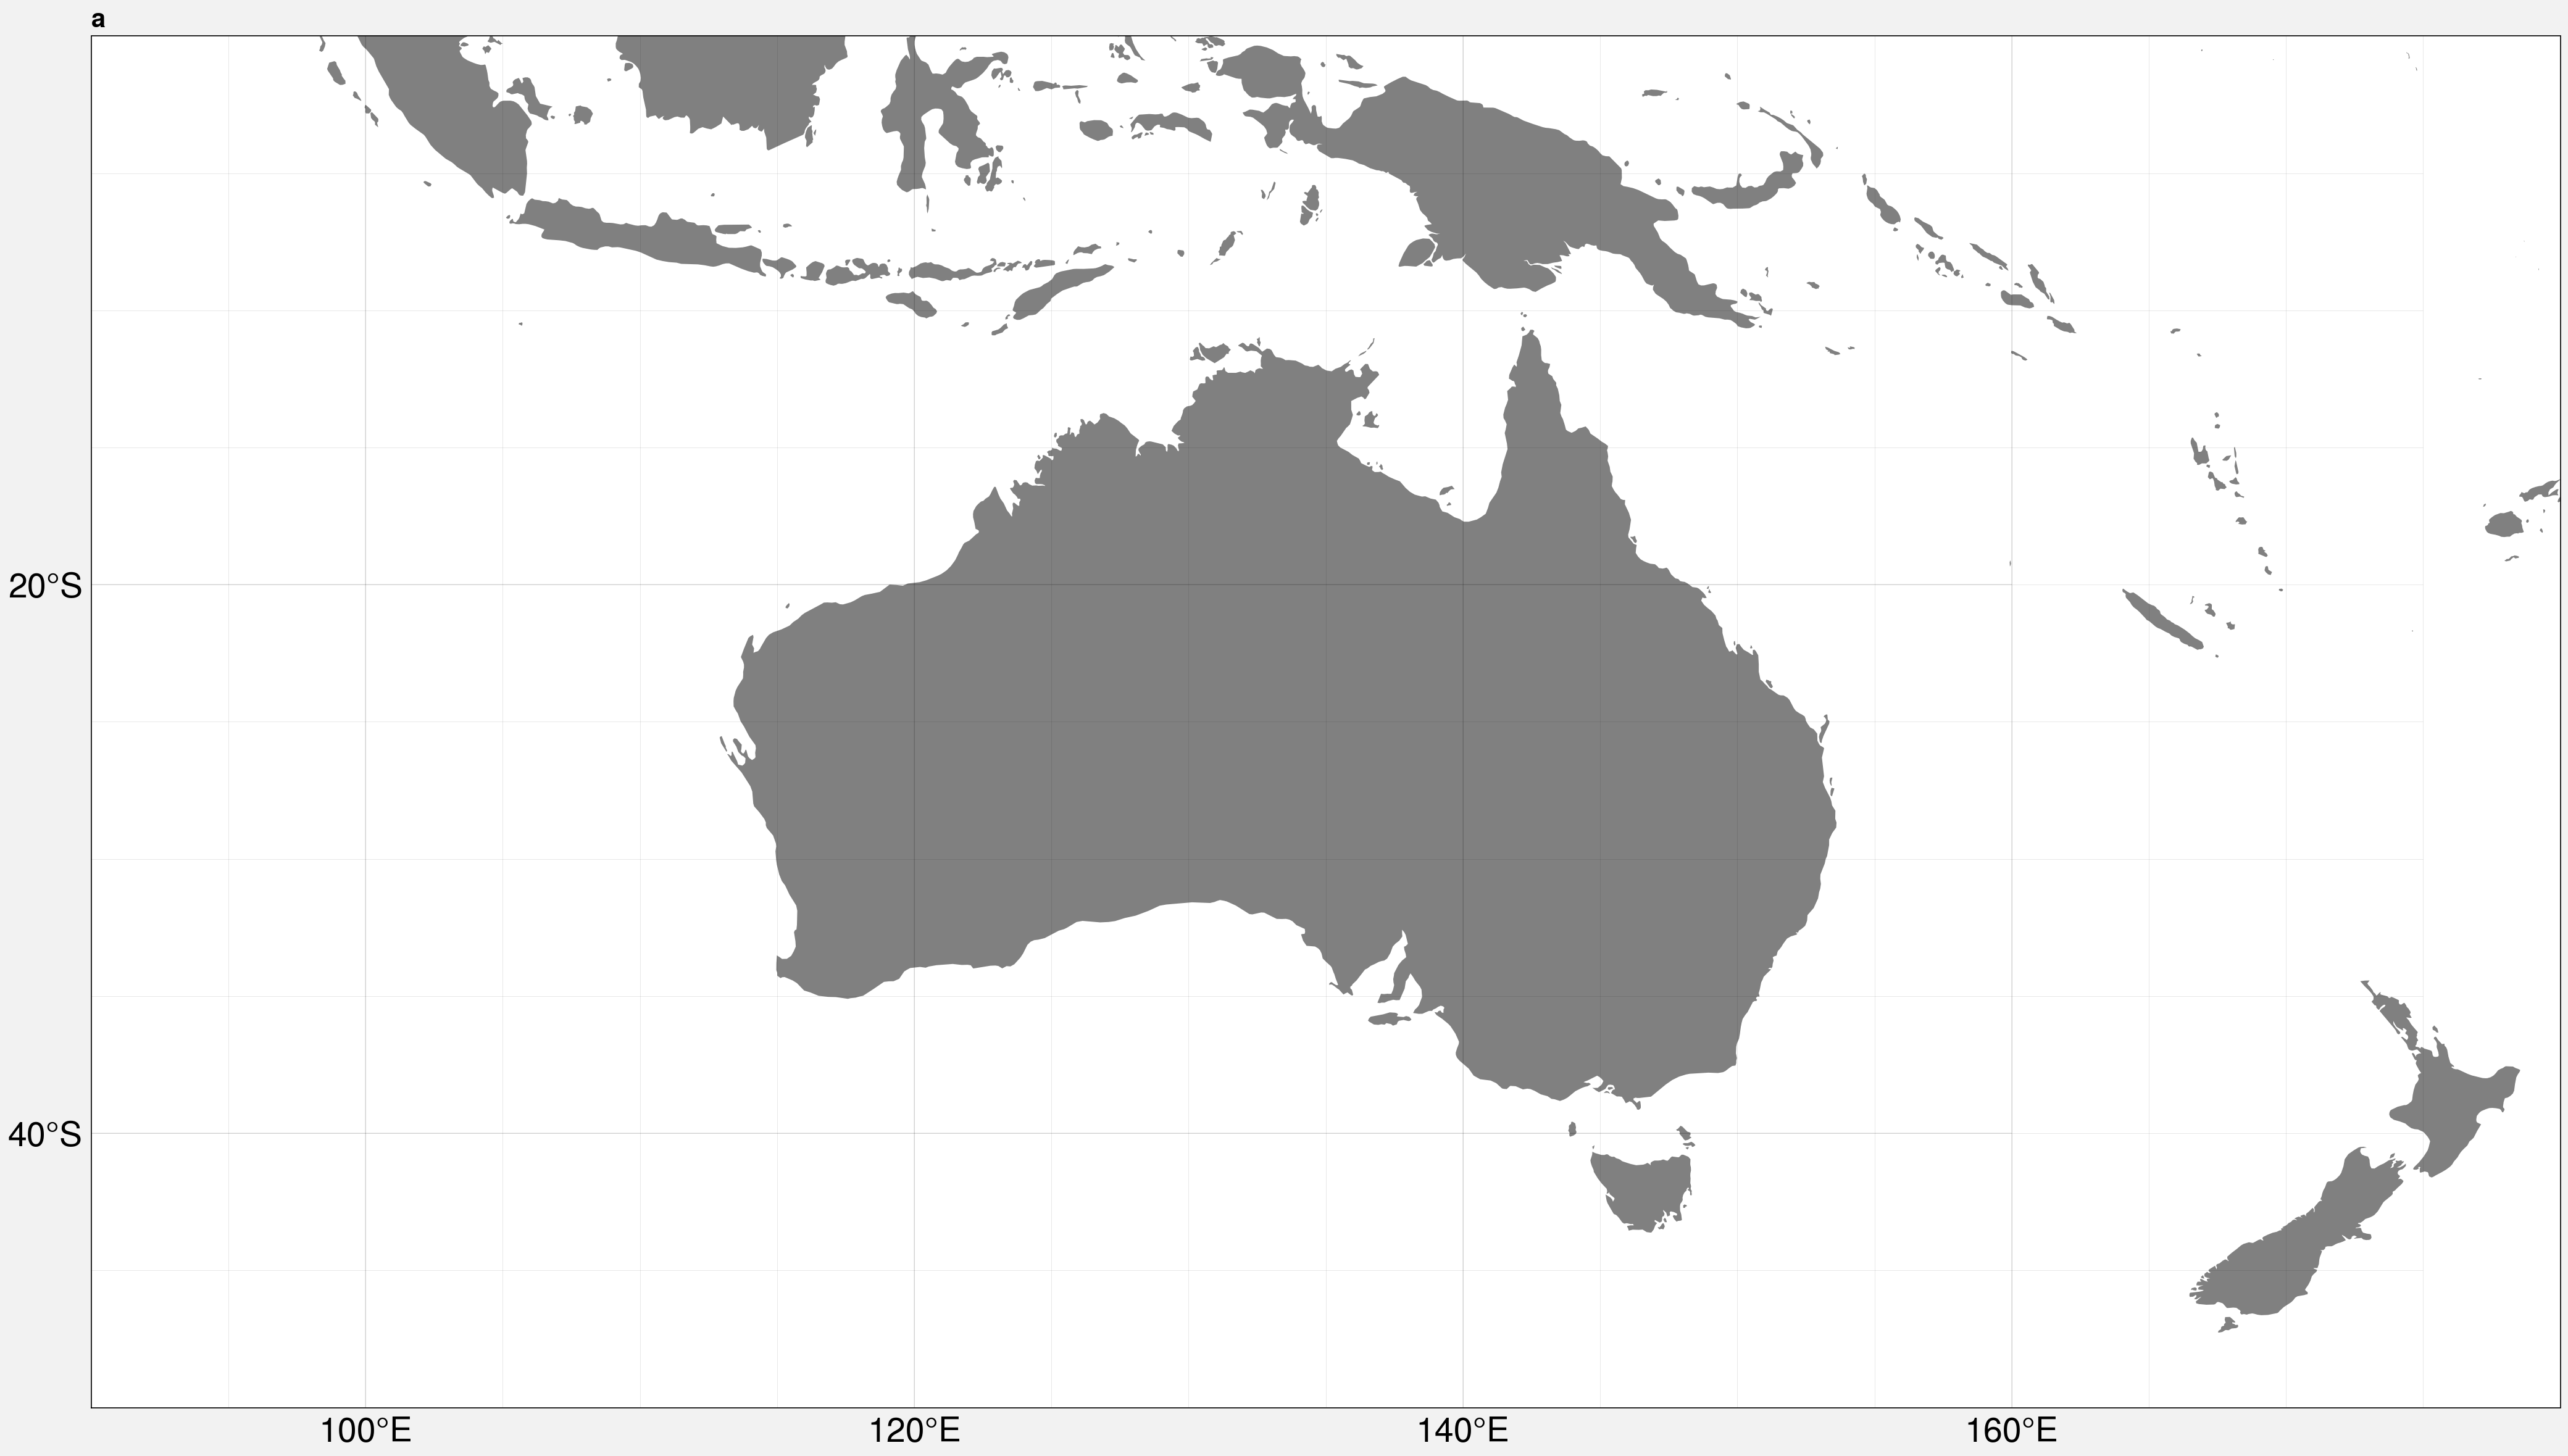

In [8]:
import proplot

LONGITUDE_LIM_WEST = 90
LONGITUDE_LIM_EAST = 180

LATITUDE_LIM_SOUTH = -50
LATITUDE_LIM_NORTH =  0

proplot.rc['abc.size'] = 15
#obs_type = ['ctd','xbt','pfl','osd','mrb','gld','drb'] #,'gld']
proplot.rc.reso = 'med'  # use higher res for zoomed in geographic features
#basemap = pplt.Proj('cyl', lonlim=(-20, 180), latlim=(-10, 50), basemap=True)
fig, axs = proplot.subplots(nrows=1, proj=('cyl'),axwidth=20)
axs.format(
    land=True, labels=True, lonlines=20, latlines=20,
    gridminor=True,landcolor='grey', abc='a)'
)


axs[0].format(lonlim=(LONGITUDE_LIM_WEST, LONGITUDE_LIM_EAST), latlim=(LATITUDE_LIM_SOUTH, LATITUDE_LIM_NORTH), labels=True,gridlabelsize=20)



In [9]:

DELTA_LON = 0.05
DELTA_LAT = 0.05
depth_levels_interp = CSIRO_standard_levels()

#obs_type = ['ctd','xbt','pfl','osd','mrb','gld','drb'] #,'gld']


#i_year_to_get = year_to_get-START_YEAR

obs_type = ['ctd','xbt','pfl','mrb'] #,'gld'] #,'drb']

longitude_grid = np.arange(LONGITUDE_LIM_EAST,LONGITUDE_LIM_EAST+0.5*DELTA_LON,DELTA_LON)
latitude_grid  = np.arange(LATITUDE_LIM_SOUTH,LATITUDE_LIM_NORTH+0.5*DELTA_LAT,DELTA_LON)

#lonr = -270.:dx:-180.; # the range of longitudes (start:step:end)
#latr = -50.:dy:0.;

variables_to_process = ['Temperature','Salinity','Pressure'] #OXygen

interpolated_data_container = {}

interpolated_data_container_for_year = {}


for i_year in range(START_YEAR,END_YEAR+1):
    print('===========================')

    print('Operating on year: ', i_year)
    data_container_for_year = data_container[i_year]

    for i_obs_type in obs_type:
    
        print(i_obs_type)
        meets_condition = ( (data_container_for_year[i_obs_type]['lat']>=LATITUDE_LIM_SOUTH) & (data_container_for_year[i_obs_type]['lat']<=LATITUDE_LIM_NORTH) 
                          & (data_container_for_year[i_obs_type]['lon']>=LONGITUDE_LIM_WEST) & (data_container_for_year[i_obs_type]['lon']<=LONGITUDE_LIM_EAST)  ) 


        casts_in_box = data_container_for_year[i_obs_type]['casts'][meets_condition]
    
    #dsa
    
    
        print('found ', meets_condition.values.sum(), ' profiles.')
        for i_var in variables_to_process:
            if i_var in data_container_for_year[i_obs_type].data_vars and meets_condition.sum().values != 0:
 
                print('Interpolating: ', i_var)
                casts_to_get               = data_container_for_year[i_obs_type][i_var + '_cast_index'].isin(casts_in_box)
                var_for_casts              = data_container_for_year[i_obs_type][i_var][casts_to_get]
                var_cast_index_for_cast    = data_container_for_year[i_obs_type][i_var + '_cast_index'][casts_to_get]
                WOD_QC_flag_for_cast       = data_container_for_year[i_obs_type][i_var + '_WODflag'][casts_to_get]
                
                

                latitude_for_casts         = data_container_for_year[i_obs_type]['lat'].sel(casts=var_cast_index_for_cast)
                longitude_for_casts        = data_container_for_year[i_obs_type]['lon'].sel(casts=var_cast_index_for_cast)
                time_for_casts             = data_container_for_year[i_obs_type]['time'].sel(casts=var_cast_index_for_cast)
 
                z_casts_to_get             = data_container_for_year[i_obs_type]['z_cast_index'].isin(var_cast_index_for_cast)
                z_for_casts                = data_container_for_year[i_obs_type]['z'][z_casts_to_get]
                z_cast_index_for_cast      = data_container_for_year[i_obs_type]['z_cast_index'][z_casts_to_get]

                WOD_QC_flag_for_z_cast     = data_container_for_year[i_obs_type]['z_WODflag'][z_casts_to_get]

                
                var_for_casts[WOD_QC_flag_for_cast != 0] = np.nan
                z_for_casts[WOD_QC_flag_for_z_cast != 0] = np.nan

                
            
                interp_temperature_simple = interp_to_pressure_levels_pchip_simple(var_for_casts,var_cast_index_for_cast,
                                                                               z_for_casts,z_cast_index_for_cast,depth_levels_interp,
                                                                               latitude_for_casts,longitude_for_casts,time_for_casts)
                
                interp_temperature_simple.to_netcdf('/tube1/cha674/CARS_2022_ancillary_data/WOD_intermediate/WOD_' +str(i_year) + '_' 
                                                + str(i_var) + '_' + i_obs_type + '.CARS_region.interp_standard_level.nc')
            else:
                 print('No variable ', i_var, ' in ', i_obs_type )
                    


Operating on year:  2005
ctd
found  1014  profiles.
Interpolating:  Temperature


NameError: name 'dasdad' is not defined

In [46]:
def interp_to_pressure_levels_trevor_paul(data,data_cast_index,pressure,pressure_cast_index,pressure_levels_interp):
    import gsw as TEOS_10

    scale_factor = 0.33
    min_obs_for_interp = 4

    unique_cast_identifer = np.unique(data_cast_index)
    
    data_interp_simple  = np.zeros([unique_cast_identifer.size,pressure_levels_interp.size],dtype=np.float32)
    data_interp         = np.zeros([unique_cast_identifer.size,pressure_levels_interp.size],dtype=np.float32)

    cast_counter = 0
    
    #Pre-computed constants
    sin_pi_on_16  = 1.950903220161283e-1  # %sin_pi_on_16 = sin(pi./16)
    cos_pi_on_16  = 9.807852804032304e-1  # %cos_pi_on_16 = cos(pi./16)
    sin_pi_on_8   = 3.826834323650898e-1  # %sin_pi_on_8 = sin(pi./8)
    cos_pi_on_8   = 9.238795325112867e-1  # %cos_pi_on_8 = cos(pi./8)
    sin_3pi_on_16 = 5.555702330196022e-1  # %sin_3pi_on_16 = sin(3pi./16)
    cos_3pi_on_16 = 8.314696123025452e-1  # %cos_3pi_on_16 = cos(3pi./16)
    sin_pi_on_4   = 7.071067811865475e-1  # %sin_pi_on_8 = sin(pi./4)
    cos_pi_on_4   = 7.071067811865476e-1  # %cos_pi_on_8 = cos(pi./4)
    sin_5pi_on_16 = 8.314696123025452e-1  # %sin_pi_on_8 = sin(5pi./16)
    cos_5pi_on_16 = 5.555702330196023e-1  # %cos_pi_on_8 = cos(5pi./16)
    sin_3pi_on_8  = 9.238795325112867e-1  # %sin_pi_on_8 = sin(3pi./8)
    cos_3pi_on_8  = 3.826834323650898e-1  # %cos_pi_on_8 = cos(3pi./8)
    sin_7pi_on_16 = 9.807852804032304e-1  # %sin_pi_on_8 = sin(7pi./16)
    cos_7pi_on_16 = 1.950903220161283e-1  # %cos_pi_on_8 = cos(7pi./16)
    
    
    
    for i_cast in unique_cast_identifer:
        print(i_cast)
        
        
        
        i_cast_index = np.nonzero(data_cast_index.values==i_cast)
        
        pressure_obs  = pressure[i_cast_index]
        data_obs      = data[i_cast_index]
        
        min_pressure = pressure_obs.min()
        max_pressure  = pressure_obs.max()
        print(min_pressure.values)
        print(max_pressure.values)
        
        
        #print(pressure_levels_interp)
        idx_to_interp = np.nonzero( np.logical_and(pressure_levels_interp <=max_pressure.values,
                                                   pressure_levels_interp >=min_pressure.values) )[0]
        
        idx_too_shallow = np.nonzero(pressure_levels_interp <min_pressure.values) [0]
        idx_too_deep    = np.nonzero(pressure_levels_interp >max_pressure.values) [0]
        
        

        if pressure_obs.size > min_obs_for_interp:
            
            independent_variable     = np.arange(0,pressure_obs.size,1)
            independent_variable_interp   = TEOS_10.pchip_interp(independent_variable,pressure_obs,pressure_levels_interp[idx_to_interp])
            
    
            tor = scale_factor*np.arange(0,pressure_obs.size)
            v1_tmp = data_obs
            q1_tmp = tor
            v1_i  = TEOS_10.pchip_interp(independent_variable,v1_tmp,independent_variable_interp )
            q1_i  = TEOS_10.pchip_interp(independent_variable,q1_tmp,independent_variable_interp )

            v2_tmp = tor*sin_pi_on_16 + data_obs*cos_pi_on_16
            q2_tmp = tor*cos_pi_on_16 - data_obs*sin_pi_on_16
            v2_i  = TEOS_10.pchip_interp(independent_variable,v2_tmp,independent_variable_interp )
            q2_i  = TEOS_10.pchip_interp(independent_variable,q2_tmp,independent_variable_interp )

            v3_tmp = tor*sin_pi_on_8 + data_obs*cos_pi_on_8
            q3_tmp = tor*cos_pi_on_8 - data_obs*sin_pi_on_8
            v3_i  = TEOS_10.pchip_interp(independent_variable,v3_tmp,independent_variable_interp )
            q3_i  = TEOS_10.pchip_interp(independent_variable,q3_tmp,independent_variable_interp )
            
            v4_tmp = tor*sin_3pi_on_16 + data_obs*cos_3pi_on_16
            q4_tmp = tor*cos_3pi_on_16 - data_obs*sin_3pi_on_16
            v4_i  = TEOS_10.pchip_interp(independent_variable,v4_tmp,independent_variable_interp )
            q4_i  = TEOS_10.pchip_interp(independent_variable,q4_tmp,independent_variable_interp )
            
            v5_tmp = tor*sin_pi_on_4 + data_obs*cos_pi_on_4
            q5_tmp = tor*cos_pi_on_4 - data_obs*sin_pi_on_4
            v5_i  = TEOS_10.pchip_interp(independent_variable,v5_tmp,independent_variable_interp )
            q5_i  = TEOS_10.pchip_interp(independent_variable,q5_tmp,independent_variable_interp )
            
            v6_tmp = tor*sin_5pi_on_16 + data_obs*cos_5pi_on_16
            q6_tmp = tor*cos_5pi_on_16 - data_obs*sin_5pi_on_16
            v6_i  = TEOS_10.pchip_interp(independent_variable,v6_tmp,independent_variable_interp )
            q6_i  = TEOS_10.pchip_interp(independent_variable,q6_tmp,independent_variable_interp )
            
            v7_tmp = tor*sin_3pi_on_8 + data_obs*cos_3pi_on_8
            q7_tmp = tor*cos_3pi_on_8 - data_obs*sin_3pi_on_8
            v7_i  = TEOS_10.pchip_interp(independent_variable,v7_tmp,independent_variable_interp )
            q7_i  = TEOS_10.pchip_interp(independent_variable,q7_tmp,independent_variable_interp )
            
            v8_tmp = tor*sin_7pi_on_16 + data_obs*cos_7pi_on_16
            q8_tmp = tor*cos_7pi_on_16 - data_obs*sin_7pi_on_16
            v8_i  = TEOS_10.pchip_interp(independent_variable,v8_tmp,independent_variable_interp )
            q8_i  = TEOS_10.pchip_interp(independent_variable,q8_tmp,independent_variable_interp )
            
            data_i_1 = v1_i

            data_i_2 = -q2_i*sin_pi_on_16 + v2_i*cos_pi_on_16
    
            data_i_3 = -q3_i*sin_pi_on_8 + v3_i*cos_pi_on_8
    
            data_i_4 = -q4_i*sin_3pi_on_16 + v4_i*cos_3pi_on_16
    
            data_i_5 = -q5_i*sin_pi_on_4 + v5_i*cos_pi_on_4
    
            data_i_6 = -q6_i*sin_5pi_on_16 + v6_i*cos_5pi_on_16
    
            data_i_7 = -q7_i*sin_3pi_on_8 + v7_i*cos_3pi_on_8
    
            data_i_8 = -q8_i*sin_7pi_on_16 + v8_i*cos_7pi_on_16
    
            data_i_sum = 0.125*(data_i_1 + data_i_2 + data_i_3 + data_i_4 + data_i_5 + data_i_6 + data_i_7 + data_i_8)
            
            data_interp[cast_counter,idx_to_interp] = data_i_sum
            data_interp[cast_counter,idx_too_shallow] = np.nan
            data_interp[cast_counter,idx_too_deep] = np.nan

            
            data_interp_simple[cast_counter,:] = TEOS_10.pchip_interp(pressure_obs,data_obs,pressure_levels_interp )
            data_interp_simple[cast_counter,idx_too_shallow] = np.nan
            data_interp_simple[cast_counter,idx_too_deep] = np.nan

            
        else:
            data_interp_simple[cast_counter,:] = np.nan
            data_interp[cast_counter,:]        = np.nan

            
        cast_counter = cast_counter+1
    return data_interp_simple,data_interp